## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [7]:
import os
print(os.getcwd())
path='/home/ubuntu/fastai-courses/course-v3/nbs/dl1/data/salt'

!kaggle competitions download -c tgs-salt-identification-challenge

/home/ubuntu/fastai-courses/course-v3/nbs/dl1
  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 5.20MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 40.2MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 922k/922k [00:00<00:00, 34.7MB/s]
 94%|█████████████████████████████████████▋  | 154M/163M [00:02<00:00, 95.8MB/s]
100%|████████████████████████████████████████| 163M/163M [00:02<00:00, 72.3MB/s]
 82%|███████████████████████████████       | 31.0M/37.9M [00:00<00:00, 49.3MB/s]
100%|██████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 69.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/home/ubuntu/fastai-courses/course-v3/nbs/dl1/salt/test.zip', 'r')
zip_ref.extractall('/home/ubuntu/fastai-courses/course-v3/nbs/dl1/salt/test')
zip_ref.close()

In [3]:
path = Config.data_path()/'salt'
path.mkdir(exist_ok=True)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/salt/train'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train.csv'),
 PosixPath('/home/ubuntu/.fastai/data/salt/test.zip'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train.zip'),
 PosixPath('/home/ubuntu/.fastai/data/salt/test')]

In [4]:

path_lbl = path/'train/masks'
path_img = path/'train/images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/salt/train/images/cb4f7abe67.png'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train/images/fdc06fea10.png'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train/images/86c675c4fb.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/salt/train/masks/cb4f7abe67.png'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train/masks/fdc06fea10.png'),
 PosixPath('/home/ubuntu/.fastai/data/salt/train/masks/86c675c4fb.png')]

NameError: name 'get_y_fn' is not defined

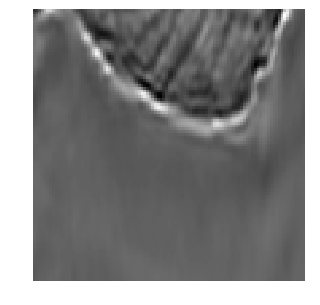

In [7]:
img_f = fnames[9]
img = open_image(img_f)
img.show(figsize=(5,5))

print(img_f,get_y_fn(img_f))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}' # converts from image to mask file name
                                                        # justt adds _P to the name

b172bd2032 .png


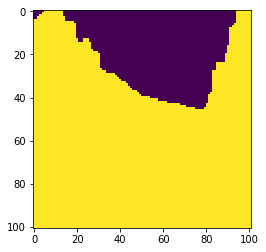

In [9]:

print(img_f.stem, img_f.suffix)
i=plt.imread('/home/ubuntu/.fastai/data/salt/train/masks/b172bd2032.png')
plt.imshow(i)
plt.show()


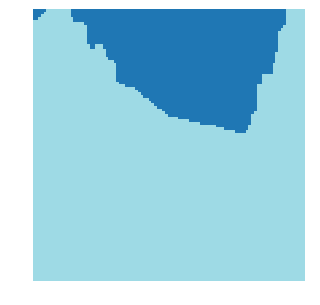

In [10]:
mask = open_mask(get_y_fn(img_f)) # fastai shows masks with distinct colors 
# or open_mask(get_y_fn(img_f))  # mask reads file as (bs,x,y) so bs=1 here
# mask also assigns ints to floats >

#Return ImageSegment object create from mask in file fn. If div, divides pixel values by 255.
mask.show(figsize=(5,5), alpha=1)

In [22]:
print(np.shape(mask), np.shape(i))
np.unique(i) 

torch.Size([1, 101, 101]) (101, 101)


array([0., 1.], dtype=float32)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([101, 101]), tensor([[[  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]]))

In [13]:

# codes = np.loadtxt(path/'codes.txt', dtype=str); codes

df=pd.read_csv('/home/ubuntu/.fastai/data/salt/train.csv')
df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


## Datasets

In [14]:
size = src_size//2 # do 1/2 image size
bs=8
codes=codes=array(['salt', 'sediment'], dtype='<U17')

In [15]:
src = (ImageFileList.from_folder(path_img)
       .label_from_func(get_y_fn)   #This method is primarly intended for inputs that are filenames, but could work in other settings.
       
       .random_split_by_pct(0.2)) # list of file names in text file
                                            # as they are from video, dont want very close frames in val

In [16]:
data = (src.datasets(SegmentationDataset,classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)# tfm_y tranform y here! as seg want same aug to mask
        .databunch(bs=bs)
        .normalize(imagenet_stats)) 

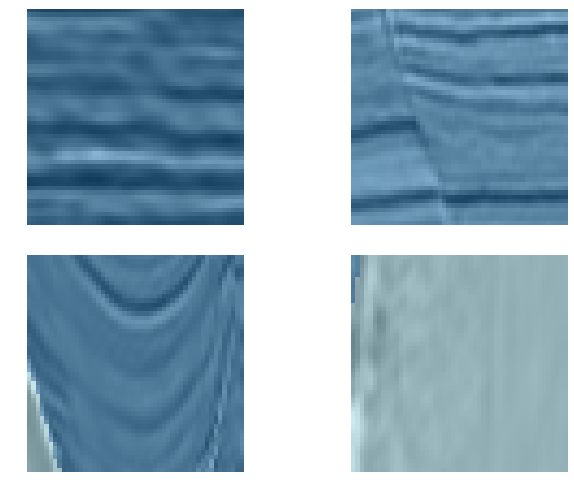

In [17]:
data.show_batch(2, figsize=(10,7)) # automtic over lays img with mask 

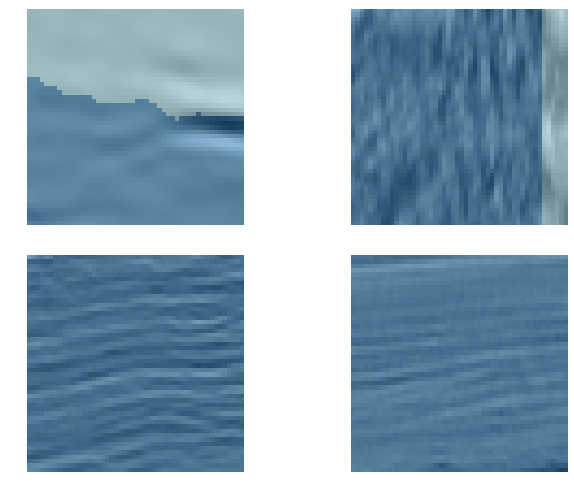

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
# name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']
# Dont want to consider label void
def salt_acc(input, target):
    target = target.squeeze(1)
    mask = target  # get boolean array of not void/void
    return (input.argmax(dim=1)==target).float().mean() # only consider pixels that are not void

In [20]:
learn = Learner.create_unet(data, models.resnet34, metrics=salt_acc) #.to_fp16() # mixed precision training, much faster
                                                                            # cuts unnecessary floats

In [21]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch-nightly_1540036376816/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [56]:
lr=1e-2

In [58]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,acc_camvid


RuntimeError: CUDA error: out of memory

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


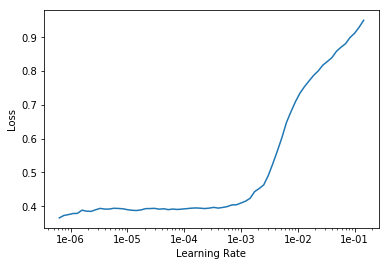

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/5)

In [ ]:
learn.fit_one_cycle(12, lrs)

Total time: 03:36
epoch  train_loss  valid_loss  acc_camvid
1      0.399582    0.338697    0.901930    (00:18)
2      0.406091    0.351272    0.897183    (00:18)
3      0.415589    0.357046    0.894615    (00:17)
4      0.407372    0.337691    0.904101    (00:18)
5      0.402764    0.340527    0.900326    (00:17)
6      0.381159    0.317680    0.910552    (00:18)
7      0.368179    0.312087    0.910121    (00:18)
8      0.358906    0.310293    0.911405    (00:18)
9      0.343944    0.299595    0.912654    (00:18)
10     0.332852    0.305770    0.911666    (00:18)
11     0.325537    0.294337    0.916766    (00:18)
12     0.320488    0.295004    0.916064    (00:18)



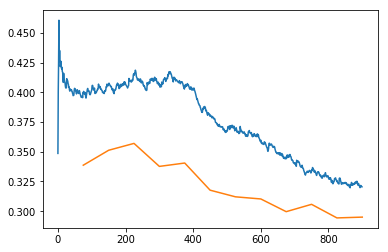

In [ ]:
learn.recorder.plot_losses()

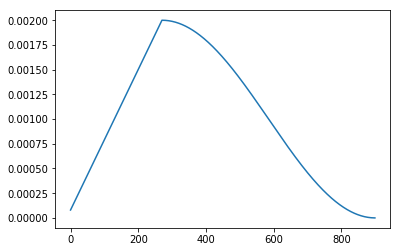

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size  # make it full image size
bs=4

In [ ]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


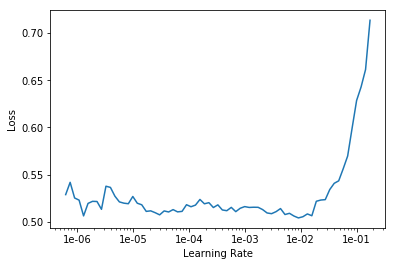

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:44
epoch  train_loss  valid_loss  acc_camvid
1      0.454597    0.349557    0.900428    (01:02)
2      0.418897    0.351502    0.897495    (00:51)
3      0.402104    0.330255    0.906775    (00:50)
4      0.385497    0.313330    0.911832    (00:51)
5      0.359252    0.297264    0.916108    (00:52)
6      0.335910    0.297875    0.917553    (00:50)
7      0.336133    0.305602    0.913439    (00:51)
8      0.321016    0.305374    0.914063    (00:51)
9      0.311554    0.299226    0.915997    (00:51)
10     0.308389    0.301060    0.915253    (00:51)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

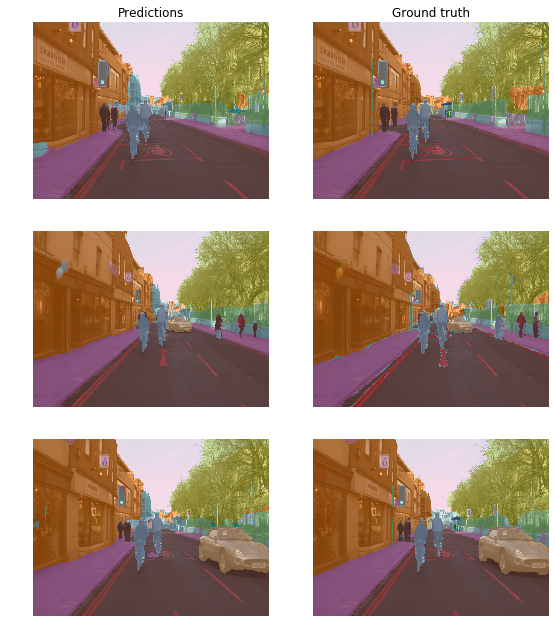

In [ ]:
learn.show_results()